**`Goal: Build a recommendation  system to propose the top 10 songs for a user based on the likelihood of listening to those songs.`**

# Importing Libraries & Data

In [ ]:
#import libraries / data
from google.colab import drive

#for data wrangling
import numpy as np
import pandas as pd
from pandas.core.groupby import groupby
from sklearn.metrics import mean_squared_error
#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
#for legibility
import warnings
warnings.filterwarnings('ignore')


**Importing data:**

**Song Data**:  
● song_id:A unique id given to every song  
● title:Title of the song  
● Release:Name of the released album  
● Artist_name:Name of the artist  
● year:Year of release   

**Count Data**:  
●user _id:A unique id given to the user  
●song_id:A unique id given to the song  
●play_count:Number of times the song was played  


In [ ]:
drive.mount("/content/drive", force_remount=True)

count_data = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/CapstoneProject/MillionSongsDataset/count_data.csv")
song_data = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/CapstoneProject/MillionSongsDataset/song_data.csv")

MessageError: ignored

#Data Exploration



In [ ]:
#dropping an unneeded column
count_data.drop(['Unnamed: 0'],axis = 1, inplace = True)

KeyError: ignored

In [ ]:
count_data.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [ ]:
count_data.shape

(2000000, 3)

In [ ]:
nonreplays = sum(count_data['play_count'] < 2)
replays = sum(count_data['play_count'] >= 2)
print('replays =',replays, 'nonreplays =',nonreplays)
#nonreplays outnumber replays, accounting for 57% of the records
(replays) / (replays + nonreplays)

replays = 861567 nonreplays = 1138433


0.4307835

In [ ]:
count_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user_id     object
 1   song_id     object
 2   play_count  int64 
dtypes: int64(1), object(2)
memory usage: 45.8+ MB


In [ ]:
count_data.isnull().sum()

user_id       0
song_id       0
play_count    0
dtype: int64

In [ ]:
count_data['user_id'].nunique()

76353

In [ ]:
song_data.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [ ]:
song_data.shape

(999980, 5)

In [ ]:
#some songs have Year 0 release date, Need to drop?
zero = song_data['year'] == 0
year_zero = song_data.loc[zero]
year_zero.shape

(484404, 5)

In [ ]:
song_data.isnull().sum()
#5 NAs in 'release' and 15 NAs in 'title'

song_id        0
title          0
release        0
artist_name    0
year           0
dtype: int64

In [ ]:
#dropping NAs like Batman
song_data = song_data.dropna(subset=['release','title'])

In [ ]:
song_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999980 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   song_id      999980 non-null  object
 1   title        999980 non-null  object
 2   release      999980 non-null  object
 3   artist_name  999980 non-null  object
 4   year         999980 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 45.8+ MB


In [ ]:
song_data['song_id'].nunique() #999036 songs by 72664 artists

999056

In [ ]:
song_data['artist_name'].nunique() #999056 songs by 72664 artists

72665

In [ ]:
song_data.song_id = song_data.song_id.str.strip()
count_data.song_id = count_data.song_id.str.strip()

In [ ]:
#need to merge count and song data
merged_data = pd.merge(count_data, song_data.drop_duplicates(['song_id']), how='left', on='song_id')


In [ ]:
merged_data.head()

,user_id,song_id,play_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [ ]:
merged_data.shape

(2000000, 7)

In [ ]:
merged_data['play_count'].describe()

count    2.000000e+06
mean     3.045485e+00
std      6.579720e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      2.213000e+03
Name: play_count, dtype: float64

In [ ]:
merged_data.loc[merged_data['play_count'] > 500].sort_values(ascending = False, by = 'play_count')

,user_id,song_id,play_count,title,release,artist_name,year
1228366,d13609d62db6df876d3cc388225478618bb7b912,SOFCGSE12AF72A674F,2213,Starshine,Gorillaz,Gorillaz,2000
1048310,50996bbabb6f7857bf0c8019435b5246a0e45cfd,SOUAGPQ12A8AE47B3A,920,Crack Under Pressure,Stress related / Live and learn,Righteous Pigs,1998
1586780,5ea608df0357ec4fda191cb9316fe8e6e65e3777,SOKOSPK12A8C13C088,879,Call It Off (Album Version),The Con,Tegan And Sara,2007
31179,bb85bb79612e5373ac714fcd4469cabeb5ed94e1,SOZQSVB12A8C13C271,796,Paradise & Dreams,Skydivin',Darren Styles,0
1875121,c012ec364329bb08cbe3e62fe76db31f8c5d8ec3,SOBONKR12A58A7A7E0,683,You're The One,If There Was A Way,Dwight Yoakam,1990
1644909,70caceccaa745b6f7bc2898a154538eb1ada4d5a,SOPREHY12AB01815F9,676,I'm On A Boat,Incredibad,The Lonely Island / T-Pain,2009
1731945,972cce803aa7beceaa7d0039e4c7c0ff097e4d55,SOJRFWQ12AB0183582,664,Dance_ Dance,Dance_ Dance,Fall Out Boy,0
1374693,d2232ac7a1ec17b283b5dff243161902b2cb706c,SOLGIWB12A58A77A05,649,Reelin' In The Years,The Definitive Collection,Steely Dan,1972
1819571,f5363481018dc87e8b06f9451e99804610a594fa,SOVRIPE12A6D4FEA19,605,Can't Help But Wait (Album Version),Kiss Presents The Mixtape,Trey Songz,0
515442,f1bdbb9fb7399b402a09fa124210dedf78e76034,SOZPMJT12AAF3B40D1,585,The Quest,A Taste Of Extreme Divinity,HYPOCRISY,2009


# Data Preparation

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Label Encoding to facilitate computation over numbers rather than long alphanumeric strings
le = LabelEncoder()

# Fit transform the user_id column
merged_data['user_id'] = le.fit_transform(merged_data['user_id'])

# Fit transform the business_id column
merged_data['song_id'] = le.fit_transform(merged_data['song_id'])
merged_data.shape

(2000000, 7)

In [ ]:
#reducing the size of the dataset by eliminating underplayed songs, less active users
# Get the column containing the users
users = merged_data.user_id

# Create a dictionary from users to their number of songs
ratings_count = dict()

for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
RATINGS_CUTOFF = 90
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
merged_data = merged_data.loc[~merged_data.user_id.isin(remove_users)]
merged_data.shape

(438390, 7)

In [ ]:
# Get the column containing the songs
songs = merged_data.song_id

# Create a dictionary from songs to their number of users
ratings_count = dict()

for song in songs:
    # If we already have the song, just add 1 to their rating count
    if song in ratings_count:
        ratings_count[song] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[song] = 1

In [ ]:
# We want our song to be listened by atleast 120 users to be considred
RATINGS_CUTOFF = 120

remove_songs = []

for song, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_songs.append(song)

complete_data= merged_data.loc[ ~ merged_data.song_id.isin(remove_songs)]
complete_data.shape

(130398, 7)

In [ ]:
songs_under5 = complete_data[complete_data['play_count'] <= 5]
songs_under5.shape

(117876, 7)

In [ ]:
songs_under5.head()

,user_id,song_id,play_count,title,release,artist_name,year
200,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000
202,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004
203,6958,549,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007
204,6958,703,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007
205,6958,719,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007


In [ ]:
songs_under5['song_id'].nunique()

563

##EDA

In [ ]:
#number of songs, users, artists
songs_under5[['song_id','user_id', 'artist_name']].nunique()

song_id         563
user_id        3155
artist_name     232
dtype: int64

In [ ]:
songs_under5['play_count'].describe()

count    117876.000000
mean          1.700058
std           1.089517
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           5.000000
Name: play_count, dtype: float64

In [ ]:
#examining most listened to songs, make top 5 most listened list
songs_under5.sort_values('play_count', ascending = False).head()

,user_id,song_id,play_count,title,release,artist_name,year
1625034,3237,3462,5,If I Had You,For Your Entertainment (Deluxe Version),Adam Lambert,2009
1751894,65100,310,5,Seven Nation Army,Seven Nation Army,The White Stripes,2003
409652,50962,7496,5,The Gift,We Don't Need To Whisper,Angels and Airwaves,2006
1753649,6692,7196,5,I Don't Need A Man,R&B Divas,The Pussycat Dolls,2005
409660,50962,8324,5,The Big Gundown,Invaders Must Die Remixes and Bonus Tracks,The Prodigy,2009


In [ ]:
#examining most active users, make top 10 most listened list
songs_under5.value_counts('user_id', ascending = False).head()
#uncomment below to see songs from a specific user
#songs_under5[trim_data["user_id"] == 6958]

user_id
61472    243
15733    227
37049    202
9570     184
23337    177
dtype: int64

In [ ]:
#removing songs with year 0 so we can look at song age statistics
no_zeroes = songs_under5.loc[songs_under5['year'] != 0].drop_duplicates()
no_zeroes['age'] = 2022 - no_zeroes['year']


In [ ]:
no_zeroes['age'].describe()

count    97227.000000
mean        18.155667
std          7.065753
min         12.000000
25%         14.000000
50%         16.000000
75%         20.000000
max         53.000000
Name: age, dtype: float64

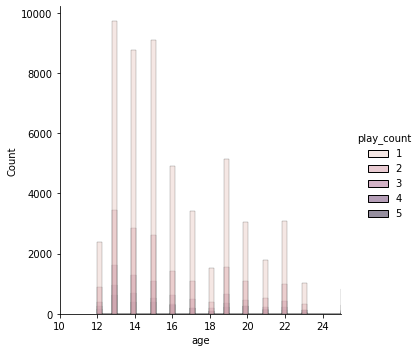

In [ ]:
#plt.hist(no_zeroes['age'])
p = sns.displot(data=no_zeroes, x='age', kind='hist', hue = 'play_count', aspect = 1)
p.set(xlim=(10,25))
#plt.savefig('count_age_year.png')

In [ ]:
#counting songs for a plot
count_songs = songs_under5.groupby('year').count()['title']
count = pd.DataFrame(count_songs)
count.drop(count.index[0], inplace = True)
count.tail()

,title
year,
2006,7592
2007,13750
2008,14031
2009,16351
2010,4087


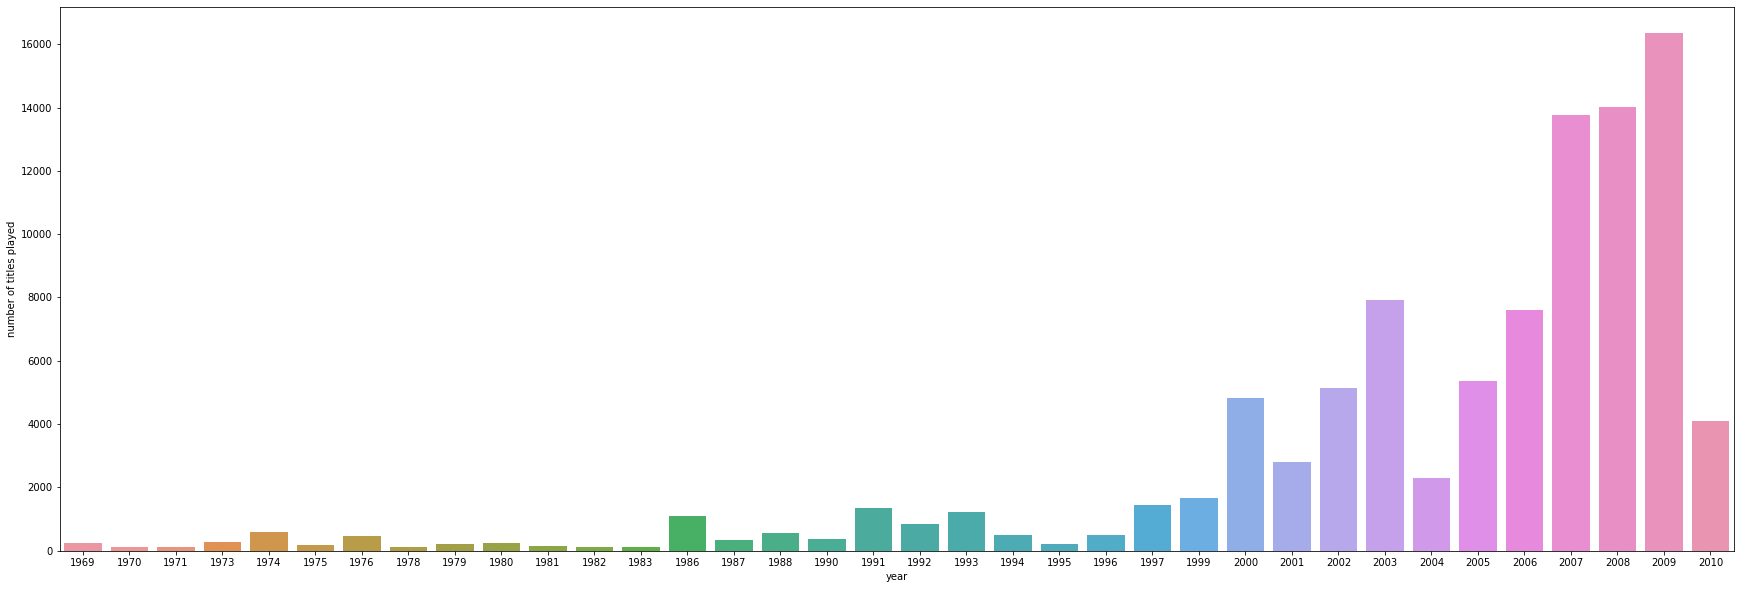

In [ ]:
# Create the plot

# Set the figure size
plt.figure(figsize = (30, 10))

sns.barplot(x = count.index,
            y = 'title',
            data = count,
            estimator = np.median)

# Set the y label of the plot
plt.ylabel('number of titles played')

# Show the plot
plt.show()

#Model Building & Optimization

###Packages & Functions

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 5.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633979 sha256=08ff34ef71652484b83c87dc510287d4539f30c430f69e0e6d58bcf974902f5d
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
# Import necessary libraries

# To compute the accuracy of models
from surprise import accuracy

# This class is used to parse a file containing play_counts, data should be in structure - user; item; play_count
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the data in train and test dataset
from surprise.model_selection import train_test_split

from collections import defaultdict

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing KFold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

In [ ]:
# The function to calulate the RMSE, precision@k, recall@k, and F_1 score
def precision_recall_at_k(model, k = 30, threshold = 1.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions=model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x : x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[ : k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[ : k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    # Command to print the overall precision
    print('Precision: ', precision)

    # Command to print the overall recall
    print('Recall: ', recall)

    # Formula to compute the F-1 score
    print('F_1 score: ', round((2 * precision * recall) / (precision + recall), 3))

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale= (0,5))

# Loading the dataset
data = Dataset.load_from_df(songs_under5[['user_id', 'song_id', 'play_count']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size= 0.4, random_state = 42)

##Rank based Recommendations

In [ ]:
# Calculate the average play_count for each product , user column becomes kind of useless
average_play = songs_under5.groupby('song_id').mean()
average_play.head()

# Calculate the count of playas for each product
count_play = songs_under5.groupby('song_id')['play_count'].size()
count_play.head()

# Create a dataframe with calculated average and count of ratings
pop_rank = average_play.merge(count_play.rename('total'), on='song_id', how = 'left')
pop_rank.head()

# Sort the dataframe by average of ratings in the descending order
pop_rank = pop_rank.sort_values(ascending = False, by='play_count')

# See the first five records of the "final_rating" dataset
pop_rank.head()

,user_id,play_count,year,total
song_id,,,,
7224,39984.467290,3.373832,2006.0,107
8324,35685.302083,2.625000,2009.0,96
6450,35656.872549,2.578431,0.0,102
9942,38427.180000,2.486667,1997.0,150
5531,38616.987055,2.309061,2009.0,618


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions

def top_n_products(pop_rank, n, min_interaction):

    # Finding products with minimum number of interactions
    recommendations = pop_rank[pop_rank['total'] > min_interaction]

    # Sorting values with respect to average rating
    recommendations = pop_rank.sort_values(ascending = False, by = 'play_count')
    line= '\n'
    print(f' The top {n} recommendations with at least {min_interaction} interactions include:')

   #Because I wanted to make a more useful output for this model,
   #I tried to make it spit out the title/artist information, in addition to the song_id
    top_n = recommendations.index[:n].values
    cols = ['song_id','artist_name','title']
    songs = pd.DataFrame(columns = cols)
    index = 0
    for item in top_n:
        songs.at[index,'song_id'] = item
        songs.at[index,'artist_name'] = songs_under5.query(f'song_id == {item}')['artist_name'].iloc[0]
        songs.at[index,'title'] = songs_under5.query(f'song_id == {item}')['title'].iloc[0]
        #songs.at[index,'title'] = blah
        index += 1
    print(songs)

In [ ]:
top_n_products(pop_rank,5,10)

 The top 5 recommendations with at least 10 interactions include:
  song_id   artist_name                  title
0    7224      Old 97's  Victoria (LP Version)
1    8324   The Prodigy        The Big Gundown
2    6450      Colossal     Brave The Elements
3    9942  Three Drives            Greece 2000
4    5531   OneRepublic                Secrets


## User-user Collaborative Filtering

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model
sim_user_user = KNNBasic(sim_options=sim_options, verbose= False, random_state =1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function
precision_recall_at_k(sim_user_user)

#testing different thresholds
#threshold .5: P 1.0, R .974, F .987
#threshold 1.5: P .39, R .692, F .504
#threshold 3: P .008, R .003, F .004

RMSE: 1.0878
Precision:  0.396
Recall:  0.692
F_1 score:  0.504


In [ ]:
# Predicting play_count for a sample user with a listened song
sim_user_user.predict('6958', '1671', r_ui = 2, verbose = True) # Use user id 6958 and song_id 1671

user: 6958       item: 1671       r_ui = 2.00   est = 1.70   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='6958', iid='1671', r_ui=2, est=1.6989607635206787, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
# Predicting play_count for a sample user with a song not-listened by the user
sim_user_user.predict('6958', '3232', verbose = True) # Use user_id 6958 and song_id 3232

user: 6958       item: 3232       r_ui = None   est = 1.70   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='6958', iid='3232', r_ui=None, est=1.6989607635206787, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

### Optimizing (with GridSearchCV)

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine", 'pearson', "pearson_baseline"],
                              'user_based': [True], "min_support": [2, 4]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters

gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data) # Use entire data for GridSearch





In [ ]:
# Best RMSE score = 1.0457725956784205
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])
#{'k': 30, 'min_k': 9, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2}}

1.0469743799997067
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2}}


In [ ]:
# Combination of parameters that gave the best RMSE score
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'pearson_baseline',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 9, random_state = 1, min_support = 2, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 1.0521
Precision:  0.413
Recall:  0.721
F_1 score:  0.525


In [ ]:
# Predict the play count for a user who has listened to the song. Take user_id 6958, song_id 1671 and r_ui = 2
sim_user_user_optimized.predict("6958", "1671", r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.70   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='6958', iid='1671', r_ui=2, est=1.6989607635206787, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
# Predict the play count for a song that is not listened to by the user (with user_id 6958)
# Which songs not listened to?
merged_data.loc[(merged_data['user_id'] != 6958)].head()
#6958 hasn't listened to song_id 97, according to this data

sim_user_user_optimized.predict("6958", "3232", r_ui = 2, verbose = True)

user: 6958       item: 3232       r_ui = 2.00   est = 1.70   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='6958', iid='3232', r_ui=2, est=1.6989607635206787, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'song_id', values = 'play_count')

    # Extracting those song ids which the user_id has not interacted yet
    non_interacted_songs = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for song_id in non_interacted_songs:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, song_id).est

        # Appending the predicted ratings
        recommendations.append((song_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n]

In [ ]:
# Make top 5 recommendations for user_id 6958 with a similarity-based recommendation engine
recommendations = get_recommendations(songs_under5, 6958, 5, sim_user_user_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_ratings"
pred_data = pd.DataFrame(recommendations, columns = ['song_id', 'predicted_ratings'])

In [ ]:
def ranking_songs(recommendations, pred_data):
  # Sort the songs based on play counts
  ranked_songs = pred_data.loc[[items[0] for items in recommendations]].sort_values('play_count', ascending = False)[['play_count']].reset_index()

  # Merge with the recommended songs to get predicted play_count
  ranked_songs = ranked_songs.merge(pd.DataFrame(recommendations, columns = ['song_id', 'predicted_rating']), on = 'song_id', how = 'inner')

  # Rank the songs based on corrected play_counts
  ranked_songs['corrected_ratings'] = ranked_songs['predicted_rating'] - 1 / np.sqrt(ranked_songs['play_count'])

  # Sort the songs based on corrected play_counts
  ranked_songs = ranked_songs.sort_values('corrected_ratings', ascending = False)

  return ranked_songs

In [ ]:
# Applying the ranking products function and sorting it based on corrected ratings
ranking_songs(recommendations, pop_rank)

,song_id,play_count,predicted_rating,corrected_ratings
0,5531,2.309061,2.553335,1.895250
1,317,2.034063,2.518269,1.817108
2,5943,1.962175,2.390723,1.676833
3,4954,1.846995,2.406776,1.670964
4,8635,1.670968,2.396606,1.623007


###Observations & Insights:

text

## Item-item  Collaborative Filtering

In [ ]:
# Apply the item-item similarity collaborative filtering model with random_state = 1 and evaluate the model performance
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# Initialize the KNNBasic model
sim_item_item = KNNBasic(sim_options=sim_options, verbose= False, random_state =1)

# Fit the model on the training data
sim_item_item.fit(trainset)

# Compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function
precision_recall_at_k(sim_item_item)

RMSE: 1.0394
Precision:  0.307
Recall:  0.562
F_1 score:  0.397


In [ ]:
# Predicting play count for a sample user_id 6958 and song (with song_id 1671) heard by the user
sim_item_item.predict('6958', '1671', r_ui = 2, verbose = True) # Use user id 6958 and song_id 1671

user: 6958       item: 1671       r_ui = 2.00   est = 1.70   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='6958', iid='1671', r_ui=2, est=1.6989607635206787, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
# Predict the play count for a user that has not listened to the song (with song_id 1671)
#first find a user that hasnt listened to the song, made more challenging by the fact that 0 play_count rows are not included
#strategy: ID all users, and then exclude all who've played song_id=1671
series_1671 = merged_data['user_id'].loc[(merged_data['song_id'] == 1671)].drop_duplicates()
users_1671 = []
for i in series_1671:
  users_1671.append(i)
all_users = merged_data['user_id'].drop_duplicates()
nonlisteners = []
for i in all_users:
  if i in users_1671:
    continue
  else:
    nonlisteners.append(i)
nonlisteners.sort()
nonlisteners[0:10]

#apparently user 11 has not listened to song 1671
merged_data['user_id'].loc[(merged_data['song_id'] == 1671) & (merged_data['user_id'] == 11)]
sim_item_item.predict('11', '1671', verbose = True)

user: 11         item: 1671       r_ui = None   est = 1.70   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='11', iid='1671', r_ui=None, est=1.6989607635206787, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

###Optimizing Item-Item

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine", 'pearson', "pearson_baseline"],
                              'user_based': [False], "min_support": [2, 4]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters

gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data) # Use entire data for GridSearch

In [ ]:
# Best RMSE score = 1.0457725956784205
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.0237903213987025
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'min_support': 2}}


In [ ]:
# Apply the best model found in the grid search
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'pearson_baseline',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 9, random_state = 1, min_support = 2, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 1.0521
Precision:  0.413
Recall:  0.721
F_1 score:  0.525


In [ ]:
# Predict the play_count by a user(user_id 6958) for the song (song_id 1671)
sim_item_item_optimized.predict("6958", "1671", r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.70   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='6958', iid='1671', r_ui=2, est=1.6989607635206787, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
# Predicting play count for a sample user_id 6958 with song_id 3232 which is not heard by the user
sim_item_item_optimized.predict("6958", "3232", r_ui = 2, verbose = True)

user: 6958       item: 3232       r_ui = 2.00   est = 1.70   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='6958', iid='3232', r_ui=2, est=1.6989607635206787, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
# Find five most similar items to the item with inner id 0
sim_item_item_optimized.get_neighbors(0, 5)

[42, 1131, 17, 186, 249]

In [ ]:
# Making top 5 recommendations for user_id 6958 with item_item_similarity-based recommendation engine
recommendations = get_recommendations(songs_under5, 6958, 5, sim_item_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"
pred_data = pd.DataFrame(recommendations, columns = ['song_id', 'predicted_ratings'])

In [ ]:
# Applying the ranking_songs function
ranking_songs(recommendations, pop_rank)

,song_id,play_count,predicted_rating,corrected_ratings
0,5531,2.309061,2.553335,1.895250
1,317,2.034063,2.518269,1.817108
2,5943,1.962175,2.390723,1.676833
3,4954,1.846995,2.406776,1.670964
4,8635,1.670968,2.396606,1.623007


## SVD

In [ ]:
# Using SVD matrix factorization
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 1.0252
Precision:  0.41
Recall:  0.633
F_1 score:  0.498


In [ ]:
# Making prediction for user (with user_id 6958) to song (with song_id 1671), take r_ui = 2
svd.predict("6958", "1671", r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.70   {'was_impossible': False}


Prediction(uid='6958', iid='1671', r_ui=2, est=1.6989607635206787, details={'was_impossible': False})

In [ ]:
# Making a prediction for the user who has not listened to the song (song_id 3232)
svd.predict("6958", "3232", r_ui = 2, verbose = True)

user: 6958       item: 3232       r_ui = 2.00   est = 1.70   {'was_impossible': False}


Prediction(uid='6958', iid='3232', r_ui=2, est=1.6989607635206787, details={'was_impossible': False})

###Optimizing SVD

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performe 3-fold grid-search cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

1.0123532584558077
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


In [ ]:
# Build the optimized SVD model using optimal hyperparameter search
svd_optimized = SVD(n_epochs= 20, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Train the algorithm on the trainset
svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 1.0172
Precision:  0.415
Recall:  0.641
F_1 score:  0.504


In [ ]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 1671
svd_optimized.predict("6958", "1671", r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.70   {'was_impossible': False}


Prediction(uid='6958', iid='1671', r_ui=2, est=1.6989607635206787, details={'was_impossible': False})

In [ ]:
# Using svd_optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating
svd_optimized.predict("6958", "3232", r_ui = 2, verbose = True)

user: 6958       item: 3232       r_ui = 2.00   est = 1.70   {'was_impossible': False}


Prediction(uid='6958', iid='3232', r_ui=2, est=1.6989607635206787, details={'was_impossible': False})

In [ ]:
# Getting top 5 recommendations for user_id 6958 using "svd_optimized" algorithm
recommendations = get_recommendations(songs_under5, 6958, 5, svd_optimized)

In [ ]:
# Ranking songs based on above recommendations
ranking_songs(recommendations, pop_rank)

,song_id,play_count,predicted_rating,corrected_ratings
0,7224,3.373832,2.733784,2.189358
1,8324,2.625000,2.100425,1.483212
3,5653,2.296296,2.130383,1.470471
2,6450,2.578431,2.001452,1.378690
4,614,2.217158,1.991622,1.320036


# #Clustering model


In [ ]:
# Make baseline clustering model
clust_baseline = CoClustering(random_state = 1)

# Training the algorithm on the trainset
clust_baseline.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(clust_baseline)

RMSE: 1.0461
Precision:  0.368
Recall:  0.547
F_1 score:  0.44


In [ ]:
# Making prediction for user_id 6958 and song_id 1671
clust_baseline.predict("6958", "1671", r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.70   {'was_impossible': False}


Prediction(uid='6958', iid='1671', r_ui=2, est=1.6989607635206787, details={'was_impossible': False})

In [ ]:
# Making prediction for user (userid 6958) for a song(song_id 3232) not heard by the user
clust_baseline.predict("6958", "3232", r_ui = 2, verbose = True)

user: 6958       item: 3232       r_ui = 2.00   est = 1.70   {'was_impossible': False}


Prediction(uid='6958', iid='3232', r_ui=2, est=1.6989607635206787, details={'was_impossible': False})

In [ ]:
# Set the parameter space to tune
param_grid = {'n_cltr_u': [5, 6, 7, 8], 'n_cltr_i': [5, 6, 7, 8], 'n_epochs': [10, 20, 30]}

# Performe 3-fold grid-search cross-validation
gs_ = GridSearchCV(CoClustering, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

1.0621434003280144
{'n_cltr_u': 5, 'n_cltr_i': 5, 'n_epochs': 10}


In [ ]:
# Using tuned Coclustering algorithm
clust_tuned = CoClustering(n_cltr_u = 5,n_cltr_i = 5, n_epochs = 10, random_state = 1)

# Training the algorithm on the trainset
clust_tuned.fit(trainset)

# Let us compute precision@k and recall@k with k = 10
precision_recall_at_k(clust_tuned)

RMSE: 1.0654
Precision:  0.394
Recall:  0.566
F_1 score:  0.465


In [ ]:
# Using co_clustering_optimized model to recommend for userId 6958 and song_id 1671
clust_tuned.predict("6958", "1671", r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.70   {'was_impossible': False}


Prediction(uid='6958', iid='1671', r_ui=2, est=1.6989607635206787, details={'was_impossible': False})

In [ ]:
# Use Co_clustering based optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating
clust_tuned.predict("6958", "3232", r_ui = 2, verbose = True)

user: 6958       item: 3232       r_ui = 2.00   est = 1.70   {'was_impossible': False}


Prediction(uid='6958', iid='3232', r_ui=2, est=1.6989607635206787, details={'was_impossible': False})

In [ ]:
# Getting top 5 recommendations for user_id 6958 using "Co-clustering based optimized" algorithm
clustering_recommendations = get_recommendations(songs_under5, 6958, 5, clust_tuned)

In [ ]:
# Ranking songs based on the above recommendations
ranking_songs(recommendations,pop_rank)

,song_id,play_count,predicted_rating,corrected_ratings
0,7224,3.373832,2.733784,2.189358
1,8324,2.625000,2.100425,1.483212
3,5653,2.296296,2.130383,1.470471
2,6450,2.578431,2.001452,1.378690
4,614,2.217158,1.991622,1.320036


## Content-Based

In [ ]:
# Importing necessary packages to work with text data
import nltk

# Download punkt library
nltk.download("punkt")

# Download stopwords library
nltk.download("stopwords")

# Download wordnet
nltk.download("wordnet")
nltk.download('omw-1.4')

# Import regular expression
import re

# Import word_tokenizer
from nltk import word_tokenize

# Import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

# Import stopwords
from nltk.corpus import stopwords

# Import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity        # To compute the cosine similarity between vectors


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Function to tokenize the text
def tokenize(text):

    text = re.sub(r"[^a-zA-Z]"," ", text.lower())

    tokens = word_tokenize(text)

    words = [word for word in tokens if word not in stopwords.words('english')]  # Use stopwords of english

    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems

In [ ]:
songs_small = songs_under5#.sample(n = 10000, random_state = 42)
#songs_small = songs_small.set_index('title')
songs_small.shape

(117876, 7)

In [ ]:
# Concatenate the "title", "release", "artist_name" columns to create a different column named "text"
songs_small['text'] = songs_small['title'] + ' ' + songs_small['release'] + ' ' + songs_small['artist_name']


# Drop the duplicates from the title column
songs_small=songs_small.drop_duplicates('title')
print(songs_small.shape)

# Set the title column as the index
songs_small = songs_small.set_index('title')

# See the first 5 records of the df_small dataset
#songs_small.head(5)


(561, 8)


In [ ]:
# Create the series of indices from the data
indices = pd.Series(songs_small.index)

indices[ : 5]

0                 Daisy And Prudence
1    The Ballad of Michael Valentine
2          I Stand Corrected (Album)
3              They Might Follow You
4                         Monkey Man
Name: title, dtype: object

In [ ]:
tfidf = TfidfVectorizer(tokenizer = tokenize)
song_tfidf = tfidf.fit_transform(songs_small['text'].values).toarray()
pd.DataFrame(song_tfidf)

,0,1,2,3,4,5,6,7,8,9,...,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
song_tfidf.shape

(561, 1437)

In [ ]:
similar_songs = cosine_similarity(song_tfidf, song_tfidf)
similar_songs[0:10]

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.28173757, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.06567664, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
def recommendations(title, similar_songs):

    recommended_songs = []

    indices = pd.Series(songs_small.index)

    # Getting the index of the business that matches the title
    idx = indices[indices == title].index[0]

    # Creating a Series with the similarity scores in descending order
    score_series = pd.Series(similar_songs[idx]).sort_values(ascending = False)

    # Getting the indices of 10 most similar businesses
    top_10_indexes = list(score_series.iloc[1 : 11].index)

    # Let us print the top_10_indexes
    print(top_10_indexes)

    # populating the list with the titles of the best 10 matching businesses
    for i in top_10_indexes:
        recommended_songs.append(list(songs_small.index)[i])

    return recommended_songs


In [ ]:
# Make the recommendation for the song with title 'Learn To Fly'
# Case-sensitive...
recommendations('Learn To Fly',similar_songs)

[509, 234, 423, 345, 394, 370, 371, 372, 373, 375]


['Everlong',
 'The Pretender',
 'Nothing Better (Album)',
 'From Left To Right',
 'Lifespan Of A Fly',
 'Under The Gun',
 'I Need A Dollar',
 'Feel The Love',
 'All The Pretty Faces',
 'Bones']

In [ ]:
  history = songs_small['song_id'].loc[(songs_small['user_id'] == 6958)]
  sample = history.sample(10, random_state= 42)
  sample.index

Index(['Nantes', 'Love Letter To Japan', 'Monkey Man', 'Stadium Love',
       'The Bachelor and the Bride', 'What's In The Middle', 'Wet Blanket',
       'Goodnight Bad Morning', 'The Penalty', 'Daddy's Eyes'],
      dtype='object', name='title')

In [ ]:
#defining a function to estimate the precision and recall of the content-based recommender system.
#it takes a user, samples their history, calculates recommendations, and compares those recommendations to actual history
def prec_rec(user, k = 30):
  #list values of all songs listened to by user
  history = songs_small['song_id'].loc[(songs_small['user_id'] == user)]
  match = []
  recs = []
  total = []
  #sample k songs from the user's taste profile
  sample = history.sample(k, random_state= 42, replace=True).index
  #perform recommendations based on those songs
  for i in sample:
    adds = recommendations(i,similar_songs)
    for item in adds:
      recs.append(item)
  total = set(recs)
  for item in total:
    if item in history:
      match.append(item)
  #calculate Precision
  prec = len(match)/len(total)
  #calculate Recall
  rec = len(match)/len(history)
  f1 = 2/((prec**-1)+rec**-1)
  return(prec,rec,f1)
  #print(f'Precision = {prec}.')
  #print(f'Recall = {rec}.')
  #print(f'F1 = {f1}.')



In [ ]:
prec_rec(6958)

[432, 13, 288, 131, 14, 19, 202, 35, 11, 260]
[20, 24, 33, 490, 390, 373, 374, 375, 376, 377]
[13, 19, 35, 11, 340, 38, 511, 6, 447, 486]
[489, 552, 309, 487, 10, 0, 472, 32, 549, 27]
[28, 416, 407, 145, 518, 370, 24, 33, 490, 287]
[432, 13, 288, 131, 14, 19, 202, 35, 11, 260]
[121, 517, 167, 516, 278, 312, 37, 391, 380, 372]
[376, 340, 29, 207, 274, 515, 370, 335, 17, 174]
[309, 487, 0, 472, 221, 7, 32, 552, 59, 489]
[309, 487, 0, 472, 221, 7, 32, 552, 59, 489]
[518, 287, 25, 26, 90, 488, 494, 394, 475, 398]
[13, 14, 19, 11, 534, 518, 370, 65, 247, 38]
[518, 287, 25, 26, 90, 488, 494, 394, 475, 398]
[473, 478, 138, 277, 430, 448, 280, 310, 155, 346]
[25, 327, 323, 538, 128, 59, 311, 467, 116, 485]
[370, 374, 15, 379, 73, 395, 69, 403, 336, 269]
[518, 287, 25, 26, 90, 488, 494, 394, 475, 398]
[376, 340, 22, 336, 192, 366, 346, 274, 370, 415]
[455, 391, 18, 246, 517, 121, 167, 516, 451, 312]
[370, 374, 15, 379, 73, 395, 69, 403, 336, 269]
[28, 416, 407, 145, 518, 370, 24, 33, 490, 287]


(0.2109375, 0.6923076923076923, 0.32335329341317365)

#Output as HTML

In [ ]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/EthanMyersCapstoneFinal.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/EthanMyersCapstoneFinal.ipynb to html
[NbConvertApp] Writing 544828 bytes to /content/drive/MyDrive/EthanMyersCapstoneFinal.html
